In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('../../Database/DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [3]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
import joblib

In [7]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=3):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'balanced_accuracy'}
    
    gs = GridSearchCV(model,scoring=scoring, cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC',verbose=3)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [8]:
estimadores=[5,10,20,50,100,200,250]
features = [4,8,12,"auto"]
criterion=["gini","entropy"]

param_grid = {'n_estimators': estimadores, 'max_features' : features,'criterion':criterion}
rf = RandomForestClassifier(class_weight='balanced')
gs,_,_=gridSearch(rf,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_rf.pkl') #se guarda el gs para su posterior uso

Fitting 3 folds for each of 56 candidates, totalling 168 fits


/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=15439    1
9494     1
8615     0
25468    0
22559    0
        ..
11570    1
15134    0
2926     1
18334    0
21059    1
Name: DEF_PAY, Length: 24000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  4.1min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=4, n_estimators=250)
0.7704960078356168


['gs_rf.pkl']

In [9]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 

def experimentar(X,Y,oversampling=False):
    """ función para realizar experimentos con el MLP
    x: matriz de numpy con caracteristicas
    y: vector numpy con las variables a predecir
    num_hidden_layers: list de enteros con el numero de capdas
        ocultas a usar
    num_neurons: list de enteros con el numero de neuronas a usar
    
    Retorna: dataframe con 4 columnas:
        - numero de capas, numero de neuronas
        - promedio de error prueba (exactitud/eficiencia) de claisficacion y desviación estandar        
    """
    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=4, n_estimators=250,n_jobs=-1)
        if oversampling:
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
            
        model.fit(X=Xtrain, y=Ytrain)
        
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.69      0.35      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.769956,0.01883,0.651536,0.011217


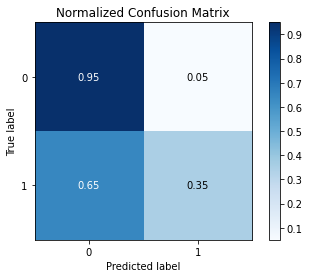

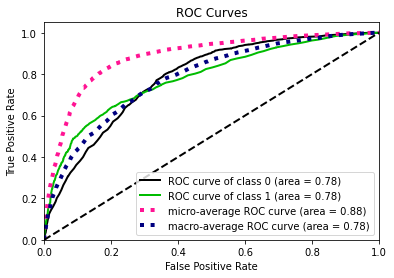

In [10]:
experimentar(X,y)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4673
           1       0.57      0.49      0.53      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.69      0.70      6000
weighted avg       0.80      0.81      0.80      6000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.759301,0.017279,0.689405,0.013982


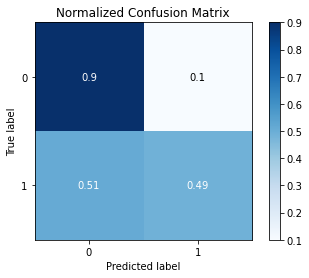

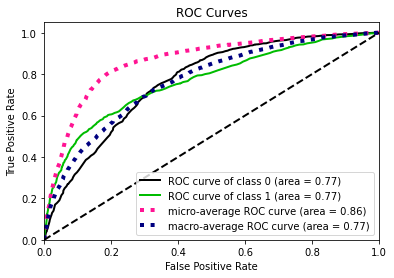

In [11]:
experimentar(X,y,oversampling=True)